# Vorstellung des Datensatzes

- Ziel: Karriereverläufe von WissenschaftlerInnen abbilden
- Orientierungspunkt für Karrieren sind die Daten:
    1. der deutschen Nationalbibliothek (DNB)
    2. ProQuest (PQ)

Tabellen, die mit 'abd_' beginnen, sind selbsterstellte Tabellen, die die Rohdaten erweitern

1. ABD_THESES
- beschreibt eine Tabelle, in der Disserationen und Habilitationen aus der DNB bzw. ProQuest Datenbank enthalten sind
- Die in diesen Datenbanken enthaltenen Personen wurden in den WoS Rohdaten gesucht und passende Matches extrahiert.
    - Matches im Sinne von: 
        1. Person muss (in etwa) denselben Namen haben
        2. Person muss in einem gewissen Zeitraum um die Dissertation an der Promotionsuniversität veröffentlicht haben
        
- Zu diesen Matches werden auf Basis der Metainformationen (Publons-ID, Orcid-ID) weitere Zeilen Personenzeilen aus den Rohdaten zugeordnet (s. Autorendisambiguierung)

2. ABD_AUTHORS
- enhält alle disambiguierten Personen aus 1. sowie alle Koautoren

<img src="resources/db_schema_abd.png" alt="Drawing" style="height:650px"/>

In [ ]:
# imports & setup
import altair as alt
import pandas as pd
import sqlalchemy as sa

import abd
from abd.dataset.models import (
    Author,
    ABDAuthor,
    ABDInstitution,
    ABDThesis,
    Item,
    ItemAuthorInstitution,
    Institution,
)

In [ ]:
_ = alt.renderers.enable("mimetype")

In [ ]:
engine, s = abd.load.dataset()

[16:23:02.480] Loaded dataset: /mnt/nvme_storage/git/abd/tmp/wos_b_2020_abd_ver-5.2.2.db


## Rohdaten


In [ ]:
n_items = s.query(sa.func.count(Item.pk_items)).subquery()
n_authors = s.query(sa.func.count(Author.pk_authors)).subquery()
n_abd_authors = s.query(sa.func.count(ABDAuthor.id)).subquery()
n_institutions = s.query(sa.func.count(Institution.pk_institutions)).subquery()
n_abd_institutions = s.query(sa.func.count(ABDInstitution.id)).subquery()

n_pq_theses = (
    s.query(sa.func.count(ABDThesis.id))
    .filter_by(dataset="ProQuest", doctype="DISS")
    .subquery()
)
n_dnb_theses = (
    s.query(sa.func.count(ABDThesis.id))
    .filter_by(dataset="DNB", doctype="DISS")
    .subquery()
)


query = s.query(
    n_items.as_scalar().label("n_items"),
    n_authors.as_scalar().label("n_authors"),
    n_abd_authors.as_scalar().label("n_abd_authors"),
    n_institutions.as_scalar().label("n_institutions"),
    n_abd_institutions.as_scalar().label("n_abd_institutions"),
    n_pq_theses.as_scalar().label("PQ Theses"),
    n_dnb_theses.as_scalar().label("DNB Theses"),
)

In [ ]:
pd.read_sql(query.statement, engine).T.reset_index().rename(
    {"index": "Tabelle", 0: "Länge"}, axis=1
)

,Tabelle,Länge
0,n_items,2510618
1,n_authors,4388830
2,n_abd_authors,3664564
3,n_institutions,2965715
4,n_abd_institutions,35951
5,PQ Theses,29104
6,DNB Theses,8323


# Autoren im Datensatz

In [ ]:
query = (
    s.query(ABDAuthor.cntry_sample, ABDAuthor.disc_sample, sa.func.count(ABDAuthor.id))
    .group_by(ABDAuthor.cntry_sample, ABDAuthor.disc_sample)
    .filter(ABDAuthor.disc_sample != "coauthor")
)

pd.read_sql(query.statement, engine).sort_values(
    ["cntry_sample", "disc_sample"]
).rename({"count_1": "N Autoren"}, axis=1)

,cntry_sample,disc_sample,N Autoren
0,DEU,biochemistry,2187
1,DEU,physics,5417
2,DEU,psychology,719
3,USA,biochemistry,7119
4,USA,physics,11561
5,USA,psychology,10424


### Anzahl Autoren über Zeit (nach sample)

In [ ]:
query = (
    s.query(ABDAuthor)
    .join(ABDThesis)
    .filter(ABDAuthor.disc_sample != "coauthor", ABDThesis.year > 2005)
    .group_by(ABDAuthor.disc_sample, ABDThesis.year)
    .with_entities(
        ABDThesis.year,
        ABDAuthor.disc_sample,
        sa.func.count(ABDAuthor.id).label("n_authors"),
    )
)

df = pd.read_sql(query.statement, engine)

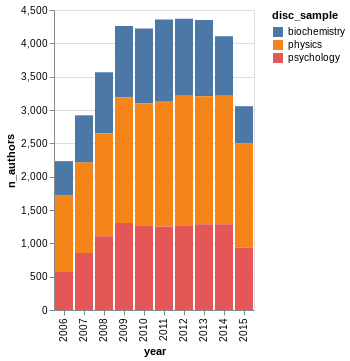

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.X("year:O"), alt.Y("n_authors:Q"), alt.Color("disc_sample:N")
)

### Durschnittliche Anzahl pk_authors pro Autor im Sample

In [ ]:
query = (
    s.query(ABDAuthor)
    .join(ABDThesis)
    .join(Author)
    .filter(ABDAuthor.disc_sample != "coauthor", ABDThesis.year > 2005)
    .group_by(ABDAuthor.id)
    .with_entities(
        ABDAuthor.id,
        ABDThesis.year,
        sa.func.count(Author.pk_authors).label("n_raw_authors"),
    )
)

df = pd.read_sql(query.statement, engine)

df = df.groupby("year")["n_raw_authors"].mean().reset_index()

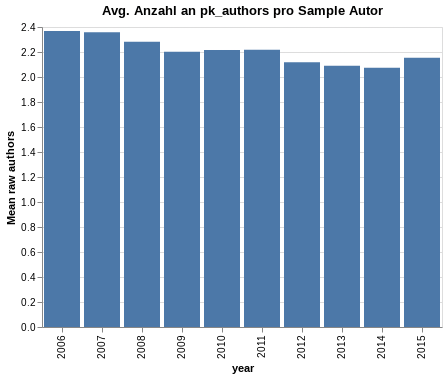

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.X("year:O"),
    alt.Y("n_raw_authors", axis=alt.Axis(title="Mean raw authors")),
).properties(
    title="Avg. Anzahl an pk_authors pro Sample Autor",
    width=400,
    height=300,
)

### Anzahl pk_authors pro Autor im gesamten Datensatz

In [ ]:
query = (
    s.query(ABDAuthor)
    .join(Author)
    .group_by(ABDAuthor.id)
    .with_entities(
        ABDAuthor.id,
        sa.func.count(Author.pk_authors).label("n_raw_authors"),
    )
)

df = pd.read_sql(query.statement, engine)

df["n"] = 1
df = df.groupby("n_raw_authors")["n"].sum().reset_index()

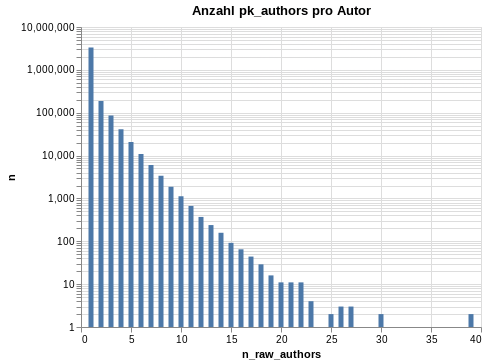

In [ ]:
alt.Chart(df).mark_bar().encode(
    alt.X("n_raw_authors:Q"),
    alt.Y("n:Q", scale=alt.Scale(type="log")),
).properties(
    title="Anzahl pk_authors pro Autor",
    width=400,
    height=300,
)

# Items im Datensatz

In [ ]:
query = (
    s.query(Item)
    .group_by(Item.doctype, Item.pubyear)
    .with_entities(
        Item.doctype,
        Item.pubyear,
        sa.func.count(Item.pk_items).label("n_articles"),
    )
)

df = pd.read_sql(query.statement, engine)

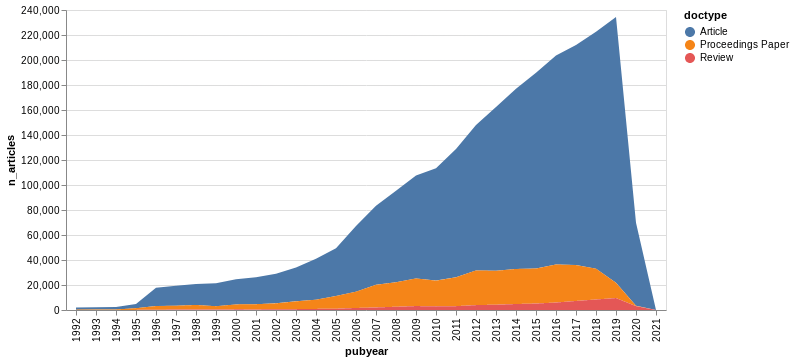

In [ ]:
alt.Chart(df).mark_area().encode(
    alt.X("pubyear:O"), alt.Y("n_articles:Q"), alt.Color("doctype:N")
)

## Autorendisambiguierung

- Beispielfall: Hans-Joachim Elmers

In [ ]:
s.query(ABDAuthor).filter_by(id=254623).one()

ABDAuthor(id=254623, firstname=Hans-Joachim , lastname=Elmers, fullname=Elmers, Hans-Joachim , orig_sample_id=None, gender=None, disc_sample=coauthor, cntry_sample=None, prof_since=None)

In [ ]:
query = (
    s.query(ABDAuthor).join(Author).filter(ABDAuthor.id == 254623).with_entities(Author)
)
pd.read_sql(query.statement, engine)

,pk_authors,fullname,middlename,author_group,role,orcid_id,orcid_id_tr,r_id,r_id_tr,author_id,firstname,lastname
0,2593200,"Elmers, HJ",None,None,author,None,None,None,None,254623,H. -J.,Elmers
1,7979166,"Elmers, Hans-Joachim",None,None,researcher_id,0000-0002-2525-9954,None,D-6729-2011,None,254623,Hans-Joachim,Elmers
2,14008505,"Elmers, H",None,None,author,None,None,D-6729-2011,None,254623,H,Elmers
3,14529075,"Elmers, HJ",None,None,author,None,None,D-6729-2011,None,254623,Hans J.,Elmers
4,19132237,"Elmers, HJ",None,None,author,None,None,D-6729-2011,None,254623,H. J.,Elmers
5,21636595,"Elmers, HJ",None,None,author,None,None,None,None,254623,Hans Joachim,Elmers
6,24304346,"Elmers, HJ",None,None,author,None,None,None,None,254623,H. J.,Elmers
7,24390980,"Elmers, Hans-Joachim",None,None,researcher_id,None,None,D-6729-2011,None,254623,Hans-Joachim,Elmers
8,27704426,"Elmers, HJ",None,None,author,None,None,D-6729-2011,None,254623,Hans-Joachim,Elmers
9,28261982,"Elmers, HJ",None,None,author,None,None,None,None,254623,H-J,Elmers


<img src="resources/elmers_01.png" alt="Drawing" style="width:1050px"/>

In [ ]:
query1 = (
    s.query(Item)
    .join(ItemAuthorInstitution)
    .group_by(Item.pk_items)
    .filter(
        ItemAuthorInstitution.fk_authors == 2593200,
    )
)

query2 = (
    s.query(Item)
    .join(ItemAuthorInstitution)
    .group_by(Item.pk_items)
    .filter(
        ItemAuthorInstitution.fk_authors == 7979166,
    )
)

pd.read_sql(query1.intersect(query2).statement, engine)

,items_pk_items,items_pubyear,items_pubtype,items_doctype,items_d_author_cnt,items_d_ref_cnt,items_fk_sources
0,315008636,2016,Journal,Article,14,49,97451
1,25442924902,2009,Journal,Article,12,36,8370
2,20630132174,2017,Journal,Article,7,20,95039
3,15011657812,2012,Journal,Article,8,29,97451


<img src="resources/elmers_02.png" alt="Drawing" style="width:750px"/>

In [ ]:
query = (
    s.query(Item)
    .join(ItemAuthorInstitution)
    .join(Author)
    .filter(Item.pk_items == 15011657812)
    .with_entities(Author)
)

pd.read_sql(query.statement, engine).sort_values("fullname")

,pk_authors,fullname,middlename,author_group,role,orcid_id,orcid_id_tr,r_id,r_id_tr,author_id,firstname,lastname
11,29279647,"Chadov, S",None,None,author,None,None,None,None,268690,S.,Chadov
8,23677790,"Chadov, Stanislav",None,None,researcher_id,0000-0002-1160-1835,None,P-3018-2014,None,268690,Stanislav,Chadov
1,2593200,"Elmers, HJ",None,None,author,None,None,None,None,254623,H. -J.,Elmers
5,7979166,"Elmers, Hans-Joachim",None,None,researcher_id,0000-0002-2525-9954,None,D-6729-2011,None,254623,Hans-Joachim,Elmers
9,24281925,"Felser, C",None,None,author,None,None,None,None,56114,C.,Felser
0,150669,"Felser, Claudia",None,None,researcher_id,0000-0002-8200-2063,None,A-5779-2009,None,56114,Claudia,Felser
6,16302873,"Jorge, EA",None,None,author,None,None,None,None,2138489,E. Arbelo,Jorge
10,25118251,"Jourdan, M",None,None,author,None,None,None,None,289708,M.,Jourdan
7,18530443,"Jourdan, Martin",None,None,researcher_id,0000-0001-6785-0518,None,D-8506-2016,None,289708,Martin,Jourdan
14,32133706,"Klaui, M",None,None,author,None,None,None,None,212282,M.,Klaeui


<img src="resources/elmers_03.png" alt="Drawing" style="width:1070px"/>

# Institutionen im Datensatz

In [ ]:
query = (
    s.query(ABDInstitution)
    .join(Institution)
    .group_by(ABDInstitution.id)
    .with_entities(
        ABDInstitution.id,
        sa.func.count(Institution.pk_institutions).label("n_institutions"),
    )
)

df = pd.read_sql(query.statement, engine)

In [ ]:
df["n_institutions"].describe()

count    35951.000000
mean        69.943812
std        442.662943
min          1.000000
25%          2.000000
50%          4.000000
75%         19.000000
max      33478.000000
Name: n_institutions, dtype: float64

In [ ]:
df["n"] = 1
df = df.groupby("n_institutions")["n"].sum().reset_index()

In [ ]:
log_scaled = (
    alt.Chart(df)
    .mark_area()
    .encode(
        alt.X("n_institutions:Q", scale=alt.Scale(type="log")),
        alt.Y("n:Q", scale=alt.Scale(type="log")),
    )
)

reduced = (
    alt.Chart(df.loc[df["n_institutions"] < 500])
    .mark_line()
    .encode(
        alt.X("n_institutions:Q"),
        alt.Y("n:Q", scale=alt.Scale(type="log")),
    )
)

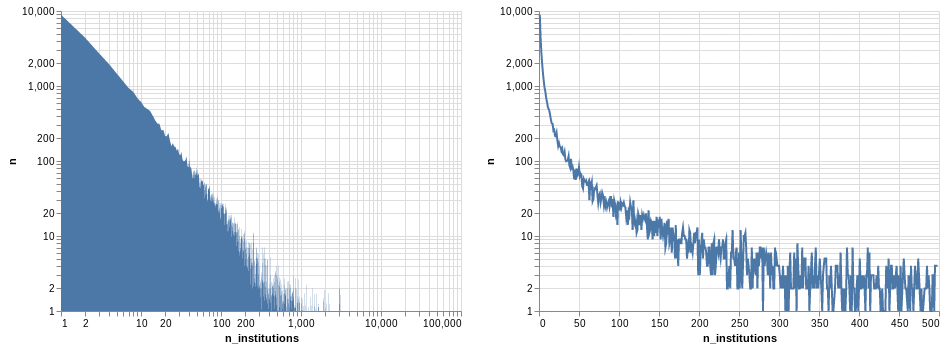

In [ ]:
log_scaled | reduced